# Electron Photon tagging

This is a first test to implement a QAE. 
The task is to identify Electrons and Photons from em-calorimeter images.

This notebook uses the full dataset stored in the /data directory at the root of the project in .hdf5 format

### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
import h5py
from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

2022-09-21 20:00:22.555632: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-21 20:00:22.555675: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/cirq/ops/gateset.py:376: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  warnings.warn(
2022-09-21 20:00:24.788588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-21 20:00:24.788628: W tensorflow/

## data

In [2]:
f = h5py.File("../../data/electron.hdf5","r")
f2 = h5py.File("../../data/photon.hdf5","r")

Check how many components might be necessary 

In [ ]:
pca = PCA().fit(f.get('X')[:,:,:,0].reshape((249000,32*32)))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [3]:
electrons = f.get('X')[:,:,:,0]
photons = f2.get('X')[:,:,:,0]
electrons_y = f.get('y')[:]
photons_y = f2.get('y')[:]

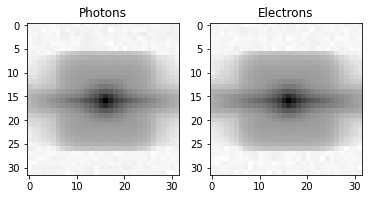

In [24]:
fig, axs = plt.subplots(1,2)
from matplotlib import cm

axs[0].imshow(np.average(photons,0), cmap="binary", norm=LogNorm())
axs[0].title.set_text('Photons')

axs[1].imshow(np.average(electrons,0), cmap="binary", norm=LogNorm())
axs[1].title.set_text('Electrons')
#fig.colorbar(cm.ScalarMappable(norm = None, cmap='binary'), ax=axs[1])

### Dimensionality reduction

To use the QAE we need to reduce the dimension as only a couple of qbits are available.
The easiest way is a simple PCA.

In [70]:
from sklearn.model_selection import train_test_split



x_train, x_val, y_train, y_val = train_test_split(np.vstack((electrons,photons)),
                                                    np.transpose(np.hstack((electrons_y, photons_y))),
                                                    test_size=0.2, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=0.4, shuffle=True)

In [72]:
DOWNSCALE = 2
DATA_DIMENSION = DOWNSCALE*DOWNSCALE
LATENT_BITS = 2

x_train, x_val, x_test = dp.PCA_reduce(x_train, DATA_DIMENSION, val_data=x_val, test_data=x_test)
print(np.max(x_train))
print(np.min(x_train))
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

1.0
0.0
(239040, 4)
(159360, 4)
(99600, 4)


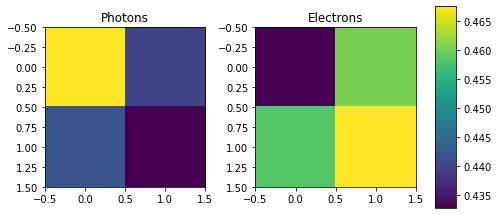

In [73]:
fig, axs = plt.subplots(1,2)
img0 = axs[0].imshow(np.average(x_train[y_train==0],0).reshape(DOWNSCALE,DOWNSCALE))
axs[0].title.set_text('Photons')

img1 = axs[1].imshow(np.average(x_train[y_train==1],0).reshape(DOWNSCALE,DOWNSCALE))
axs[1].title.set_text('Electrons')

cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
fig.colorbar(img1, orientation='vertical', cax=cbar_ax)

fig.tight_layout()

After the PCA it looks like Photons and Electrons should still seperate quite well.

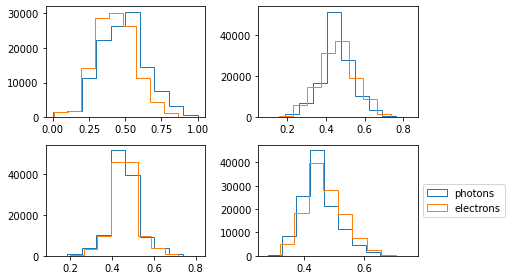

In [74]:
fig, axs = plt.subplots(DOWNSCALE,DOWNSCALE)
for i in range(0,DATA_DIMENSION):
    axs[i//DOWNSCALE,i%DOWNSCALE].hist(x_train[y_train==0][:,i], label="photons", histtype='step')
    axs[i//DOWNSCALE,i%DOWNSCALE].hist(x_train[y_train==1][:,i], label="electrons", histtype='step')
fig.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

I want only want to train the AE on Photons and later try to separate them from the electrons without training on electron data.
Therefore I only include Photons in x_train.


In [75]:
x_train_electrons = x_train[y_train==1]
x_train = x_train[y_train==0]

x_val_electrons = x_val[y_val==1]
x_val = x_val[y_val==0]

x_test_electrons = x_test[y_test==1]
x_test = x_test[y_test==0]

In [76]:
dp.input_states(x_train[0],DATA_DIMENSION,LATENT_BITS)

(0, 0): ───X^0.5202319───────────────────

(0, 1): ───X^0.40525857──────────────────

(0, 2): ───X^0.4428109───────────────────

(0, 3): ───X^0.44104204──────────────────

(0, 6): ──────────────────X^0.5202319────

(0, 7): ──────────────────X^0.40525857───

(0, 8): ──────────────────X^0.4428109────

(0, 9): ──────────────────X^0.44104204───

## QAE model

First simple implementation of a QAE

In [77]:
x_train_circuit = [dp.input_states(x,DATA_DIMENSION,LATENT_BITS) for x in x_train]
x_val_circuit = [dp.input_states(x,DATA_DIMENSION,LATENT_BITS) for x in x_val]
x_test_circuit = [dp.input_states(x,DATA_DIMENSION,LATENT_BITS) for x in x_test]

x_train_circuit_electrons = [dp.input_states(x,DATA_DIMENSION,LATENT_BITS) for x in x_train_electrons]
x_val_circuit_electrons = [dp.input_states(x,DATA_DIMENSION,LATENT_BITS) for x in x_val_electrons]
x_test_circuit_electrons = [dp.input_states(x,DATA_DIMENSION,LATENT_BITS) for x in x_test_electrons]

In [79]:
x_train_tf = tfq.convert_to_tensor(x_train_circuit)
x_val_tf = tfq.convert_to_tensor(x_val_circuit)
x_test_tf = tfq.convert_to_tensor(x_test_circuit)

x_train_tf_electrons = tfq.convert_to_tensor(x_train_circuit_electrons)
x_val_tf_electrons = tfq.convert_to_tensor(x_val_circuit_electrons)
x_test_tf_electrons = tfq.convert_to_tensor(x_test_circuit_electrons)

In [87]:
from hep_VQAE import QAE as qae

model = tf.keras.Sequential([
                             
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    
    # The PQC stands for Paramaterized Quantum Circuit
    # This returns the expectation value
    qae.QAE_layer(DATA_DIMENSION, LATENT_BITS, 7),
])

In [88]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.01))

In [90]:
y_train_ones = np.ones(shape=len(x_train_tf))
y_val_ones = np.ones(shape=len(x_val_tf))
y_test_ones = np.ones(shape=len(x_test_tf))

y_train_ones_electrons = np.ones(shape=len(x_train_tf_electrons))
y_val_ones_electrons = np.ones(shape=len(x_val_tf_electrons))
y_test_ones_electrons = np.ones(shape=len(x_test_tf_electrons))

In [91]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train_tf, y_train_ones, epochs=20, batch_size=64, validation_data=(x_val_tf, y_val_ones), callbacks=[es])

Epoch 1/20
1870/1870 [==============================] - 510s 273ms/step - loss: 0.0248 - val_loss: 0.0057
Epoch 2/20
1870/1870 [==============================] - 474s 254ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 3/20
1870/1870 [==============================] - 472s 252ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 4/20
1870/1870 [==============================] - 471s 252ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/20
1870/1870 [==============================] - 472s 252ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 6/20
1870/1870 [==============================] - 475s 254ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 7/20
1870/1870 [==============================] - 472s 253ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 8/20
1870/1870 [==============================] - 504s 270ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 9/20
1870/1870 [==============================] - 550s 294ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 10/20
1870/1870 [=======================

In [1]:
plt.plot(history.history['loss'], label="training")
plt.plot(history.history['val_loss'], label="validation")
#plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("1-Fidelity")
plt.legend()

NameError: name 'plt' is not defined

## Evaluation

0.9697734
0.96552896


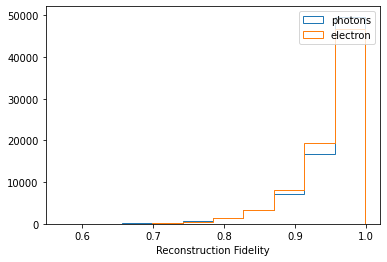

In [85]:
pred_photon = model.predict(x_test_tf)
print(np.median(pred_photon))
pred_electron = model.predict(x_test_tf_electrons)
print(np.median(pred_electron))
bins = np.histogram(np.hstack((pred_photon.reshape((pred_photon.shape[0],)), pred_electron.reshape((pred_electron.shape[0],)))), bins=10)[1]
plt.hist(pred_photon, histtype='step', label="photons",bins=bins)
plt.hist(pred_electron, histtype='step', label="electron",bins=bins)
plt.xlabel("Reconstruction Fidelity")
plt.legend()

anomaly tagging performance

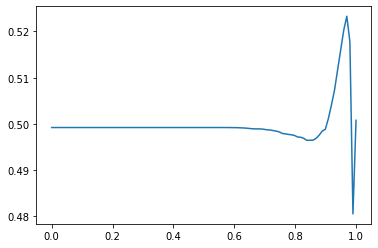

In [86]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(pred_photon > T)
    # threes that are predicted three
    num_three_right = np.sum(pred_electron < T)
    acc = (num_six_right + num_three_right)/(len(pred_photon) + len(pred_electron))
    return acc

Ts = np.linspace(0,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
plt.plot(Ts, accs)  